In [ ]:
##authors: Anna Cherkinsky and Anushka Bangal

import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras import optimizers, applications
#https://pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/


**Below is the code to load the dataset from kaggle**

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [00:41<00:00, 97.3MB/s]
100% 3.75G/3.75G [00:41<00:00, 96.5MB/s]


In [ ]:
!unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34905.jpg  
  inflating: real_v

In [ ]:
path  = '/content/real_vs_fake/real-vs-fake'

In [ ]:
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(path):
    print(where)
    for status in os.listdir(path+"/"+where):
        print(status)
        for image in glob.glob(path+"/"+where+"/"+status+"/*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

valid
real
fake
test
real
fake
train
real
fake


,image_path,img_status,where
0,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
1,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
2,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
3,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
4,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
...,...,...,...
139995,/content/real_vs_fake/real-vs-fake/train/fake/...,fake,train
139996,/content/real_vs_fake/real-vs-fake/train/fake/...,fake,train
139997,/content/real_vs_fake/real-vs-fake/train/fake/...,fake,train
139998,/content/real_vs_fake/real-vs-fake/train/fake/...,fake,train


In [ ]:
#function for FFT preprocessing
from scipy.fftpack import fftn,fftshift
def fft(image):
  ftt_img = np.abs(fftshift(fftn(image)))
  return ftt_img

In [ ]:
dataset.value_counts("img_status")

img_status
fake    70000
real    70000
dtype: int64

In [ ]:
real = dataset.value_counts("img_status")[1]
fake = dataset.value_counts("img_status")[0]

In [ ]:
nbatch = 200
train_datagen = ImageDataGenerator(preprocessing_function=fft)#rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(path + '/train/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='grayscale',
                                                 class_mode = 'binary',
                                                 shuffle=True)

Found 100000 images belonging to 2 classes.


In [ ]:
test_set = train_datagen.flow_from_directory(path + '/test/',
                                            target_size=(224, 224),
                                            batch_size =nbatch,
                                            color_mode='grayscale',
                                            class_mode = 'binary',
                                            shuffle=False)

Found 20000 images belonging to 2 classes.


In [ ]:
val_set = train_datagen.flow_from_directory(path + '/valid/',
                                            target_size=(224, 224),
                                            batch_size =nbatch,
                                            color_mode='grayscale',
                                            class_mode = 'binary',
                                           shuffle=True)

Found 20000 images belonging to 2 classes.


Below is a graph depicting image class distribution and train validation split


Text(0.5, 0, 'Class')

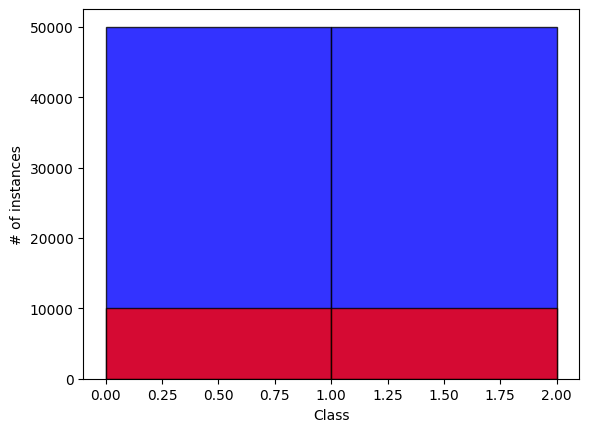

In [ ]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

**Below are the steps to initialize Xception model**

In [ ]:
baseModel = applications.Xception(weights=None,#weights="imagenet", 
                              include_top=False, 
                              input_shape=(224, 224, 1))#3))

In [ ]:
for layer in baseModel.layers[:-5]:
    layer.trainable = False

In [ ]:

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:

#used adam optimizer
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])



In [ ]:
#set call backs
checkpoint = ModelCheckpoint("xception.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_loss',  patience=10, verbose=2)

In [ ]:
#run model, this one is with FFT
history = model.fit(
                                    training_set,                   
                                    steps_per_epoch=100000//200,
                                    validation_data=val_set,                    
                                    validation_steps=20000//200,
                                    epochs=30,
                                    callbacks = [checkpoint, early],
                                    verbose=1)

Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5682
Epoch 1: val_loss improved from -inf to 0.68216, saving model to vgg16_1.h5
500/500 [==============================] - 782s 2s/step - loss: 0.6905 - accuracy: 0.5682 - val_loss: 0.6822 - val_accuracy: 0.5525
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.5849
Epoch 2: val_loss did not improve from 0.68216
500/500 [==============================] - 784s 2s/step - loss: 0.6726 - accuracy: 0.5849 - val_loss: 0.6635 - val_accuracy: 0.5994
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.5927
Epoch 3: val_loss did not improve from 0.68216
500/500 [==============================] - 750s 1s/step - loss: 0.6673 - accuracy: 0.5927 - val_loss: 0.6746 - val_accuracy: 0.5623
Epoch 4/30
500/500 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.5993
Epoch 4: val_loss did not improve from 0.68216
500

In [ ]:
model.save('Real VS Fake FTT.h5')

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

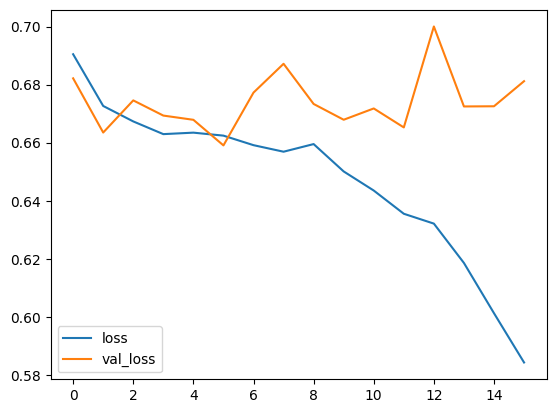

In [ ]:
losses[['loss','val_loss']].plot() #plot loss, this is with FFT

<Axes: >

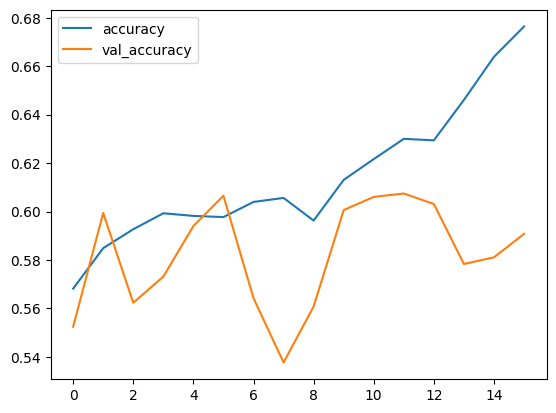

In [ ]:
losses[['accuracy','val_accuracy']].plot() #plot accuracy

In [ ]:
#predict values
y_pred = model.predict(test_set)
y_test = test_set.classes

100/100 [==============================] - 115s 1s/step


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

Below are the FFT run metrics

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.639099805
AP Score: 0.6195473571622765


In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46     10000
           1       0.56      0.83      0.67     10000

    accuracy                           0.59     20000
   macro avg       0.62      0.59      0.56     20000
weighted avg       0.62      0.59      0.56     20000



**RGB run starts here**

In [ ]:
nbatch = 200
train_datagen_norm = ImageDataGenerator()#rescale = 1./255)

In [ ]:
training_set = train_datagen_norm.flow_from_directory(path + '/train/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=True)

Found 100000 images belonging to 2 classes.


In [ ]:
test_set = train_datagen_norm.flow_from_directory(path + '/test/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=False)

Found 20000 images belonging to 2 classes.


In [ ]:
val_set = train_datagen_norm.flow_from_directory(path + '/test/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=True)

Found 20000 images belonging to 2 classes.


In [ ]:
baseModele = applications.Xception(weights="imagenet", 
                              include_top=False, 
                              input_shape=(224, 224, 3))#3))

In [ ]:
#set up the model
for layer in baseModele.layers[:-5]:
    layer.trainable = False
headModele = baseModele.output
headModele = Flatten(name="flatten")(headModele)
headModele = Dense(512, activation="relu")(headModele)
headModele = Dropout(0.5)(headModele)
headModele = Dense(1, activation="sigmoid")(headModele)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModele.input, outputs=headModele)


In [ ]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])#compile with adam

In [ ]:

history_edge = model.fit(
                                    training_set,                   
                                    steps_per_epoch=100000//200,
                                    validation_data=val_set,                    
                                    validation_steps=20000//200,
                                    epochs=30,
                                    callbacks = [checkpoint, early],
                                    verbose=1)

Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6822
Epoch 1: val_loss did not improve from 0.70003
500/500 [==============================] - 614s 1s/step - loss: 0.6454 - accuracy: 0.6822 - val_loss: 0.5866 - val_accuracy: 0.6953
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7487
Epoch 2: val_loss did not improve from 0.70003
500/500 [==============================] - 530s 1s/step - loss: 0.5140 - accuracy: 0.7487 - val_loss: 0.5149 - val_accuracy: 0.7414
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.7800
Epoch 3: val_loss did not improve from 0.70003
500/500 [==============================] - 528s 1s/step - loss: 0.4645 - accuracy: 0.7800 - val_loss: 0.4786 - val_accuracy: 0.7716
Epoch 4/30
500/500 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8070
Epoch 4: val_loss did not improve from 0.70003
500/500 [=======================

In [ ]:
model.save('Real VS Fake.h5')

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

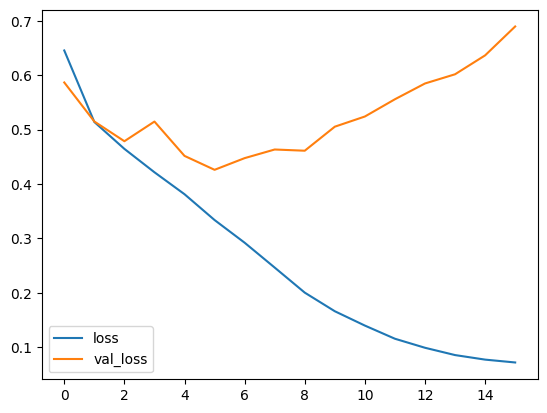

In [ ]:
losses[['loss','val_loss']].plot() #loss

<Axes: >

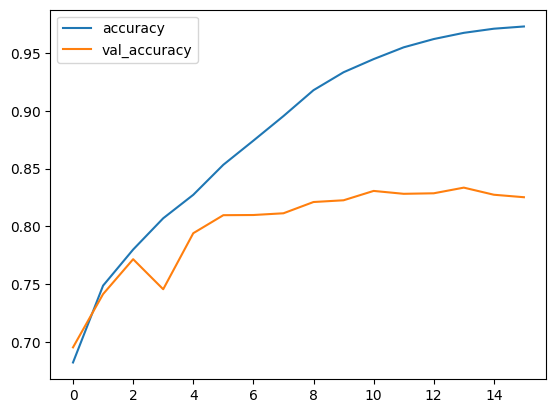

In [ ]:
losses[['accuracy','val_accuracy']].plot()#accuracy

In [ ]:
y_pred = model.predict(test_set) #predictions
y_test = test_set.classes

100/100 [==============================] - 95s 931ms/step


In [ ]:
#metrics
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.9079132000000001
AP Score: 0.9054849646862873


In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81     10000
           1       0.79      0.88      0.83     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.82     20000
weighted avg       0.83      0.83      0.82     20000



**Below is another model run accounting for overfitting**

In [ ]:
nbatch = 200
train_datagen_b = ImageDataGenerator()

In [ ]:
training_set = train_datagen_b.flow_from_directory(path + '/train/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=True)

Found 100000 images belonging to 2 classes.


In [ ]:
test_set = train_datagen_b.flow_from_directory(path + '/test/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=False)

Found 20000 images belonging to 2 classes.


In [ ]:
val_set = train_datagen_b.flow_from_directory(path + '/valid/',
                                                 target_size=(224, 224),
                                                 batch_size =nbatch,
                                                 color_mode='rgb',
                                                 class_mode = 'binary',
                                                 shuffle=True)

Found 20000 images belonging to 2 classes.


In [ ]:
baseModel2 = applications.Xception(weights="imagenet", 
                              include_top=False, 
                              input_shape=(224, 224, 3))#3))
for layer in baseModel2.layers[:-5]:
    layer.trainable = False
headModel2 = baseModel2.output
headModel2 = Flatten(name="flatten")(headModel2)
headModel2 = Dense(512, activation="relu")(headModel2)
headModel2 = Dropout(0.5)(headModel2)
headModel2 = Dense(1, activation="sigmoid")(headModel2)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel2.input, outputs=headModel2)
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:

history2 = model.fit(
                                    training_set,                   
                                    steps_per_epoch=100000//200,
                                    validation_data=val_set,                    
                                    validation_steps=20000//200,
                                    epochs=5,
                                    callbacks = [checkpoint, early],
                                    verbose=1)

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.6862

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from -inf to 0.54871, saving model to xception.h5
500/500 [==============================] - 582s 1s/step - loss: 0.6266 - accuracy: 0.6862 - val_loss: 0.5487 - val_accuracy: 0.7214
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.7500
Epoch 2: val_loss did not improve from 0.54871
500/500 [==============================] - 541s 1s/step - loss: 0.5113 - accuracy: 0.7500 - val_loss: 0.4932 - val_accuracy: 0.7588
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7815
Epoch 3: val_loss did not improve from 0.54871
500/500 [======================

In [ ]:
model.save('Real VS Fake_.h5')

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

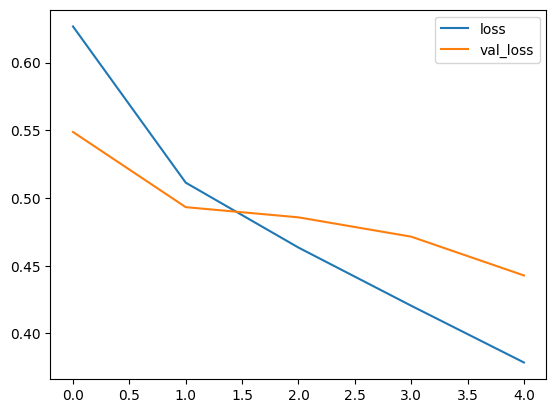

In [ ]:
losses[['loss','val_loss']].plot()

<Axes: >

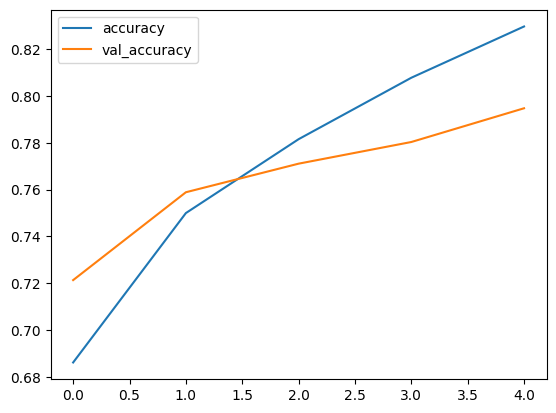

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
y_pred = model.predict(test_set)
y_test = test_set.classes

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 94s 940ms/step


In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.886739885
AP Score: 0.8856103355014106


In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78     10000
           1       0.76      0.87      0.81     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [ ]:
t = [1,3,4,5,6,7]

In [ ]:
print(t[:1])

[1]
